In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt


/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
mp.verbosity(0)
seed = 240
np.random.seed(seed)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [3]:
resolution = 20

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(1.0)]

In [4]:
fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [-1, 0, 0]
source_size = mp.Vector3(0, 2, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [5]:
design_region_resolution = 10
Nx = design_region_resolution
Ny = design_region_resolution

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
)


geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #        e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

In [6]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

In [7]:
TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, 1, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE0]

In [8]:
def J(alpha):
    return npa.abs(alpha) ** 2

In [9]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=0,
    nf=1,
)

In [10]:
x0 = np.random.rand(Nx * Ny)
opt.update_design([x0])

/home/311514090/anaconda3/envs/mp/lib/python3.10/site-packages/meep/visualization.py:366: UserWarning: The frequency parameter of plot2D has been deprecated. Use the frequency key of the eps_parameters dictionary instead.
  warnings.warn("The frequency parameter of plot2D has been deprecated. "


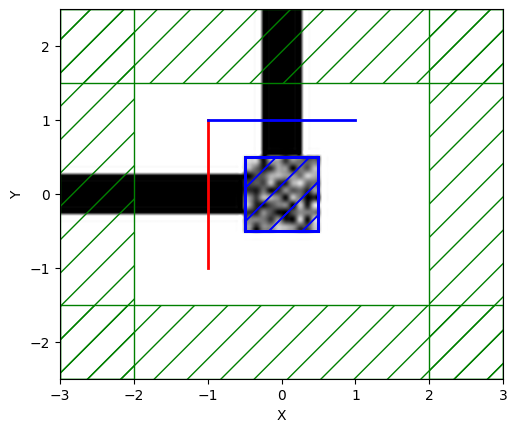

In [11]:
opt.plot2D(True, frequency=1 / 1.55)
plt.show()

In [12]:
f0, dJ_du = opt()

Starting forward run...
Starting adjoint run...
Calculating gradient...


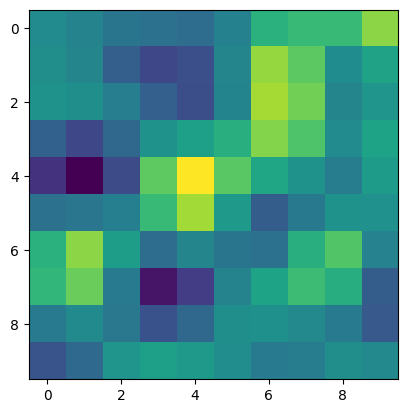

In [13]:
plt.figure()
plt.imshow(np.rot90(dJ_du.reshape(Nx, Ny)))

In [14]:
db = 1e-3
choose = 10
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

In [15]:
(m, b) = np.polyfit(np.squeeze(g_discrete), dJ_du[idx], 1)

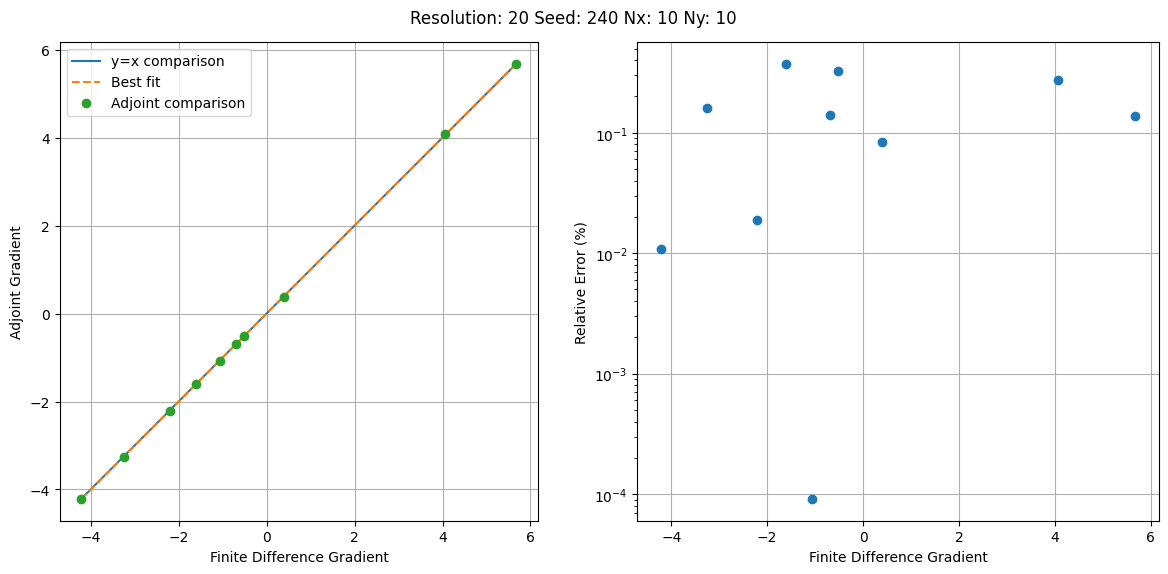

In [16]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}".format(resolution, seed, Nx, Ny))
plt.show()

In [17]:
resolution = 30
opt.sim.resolution = resolution
f0, dJ_du = opt()
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

Starting forward run...
Starting adjoint run...
Calculating gradient...


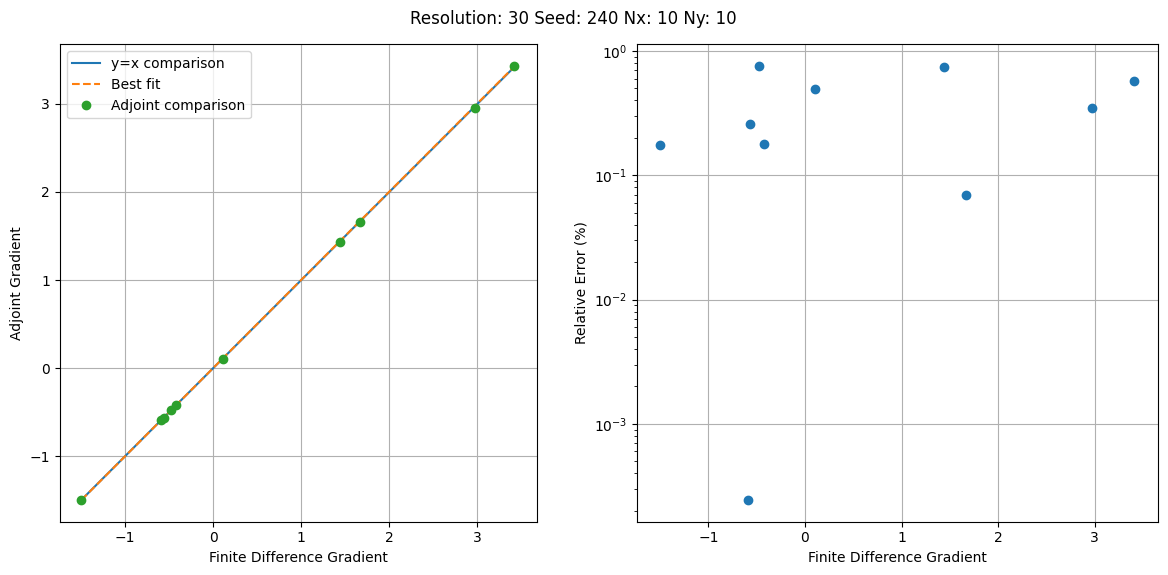

In [18]:
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}".format(resolution, seed, Nx, Ny))
plt.show()
